In [2]:
### SAME imports as Xu's fixed version

from desc.transform import Transform
from desc.equilibrium import Equilibrium
from desc.basis import ChebyshevZernikeBasis, chebyshev_z
from desc.compute import compute
from desc.grid import LinearGrid, ConcentricGrid, QuadratureGrid, Grid
from desc.compute.utils import get_transforms
from desc.objectives import (
    FixEndCapLambda,
    FixEndCapR,
    FixEndCapZ,
    FixBoundaryR,
    FixBoundaryZ,
    FixPsi,
    FixPressure,
    FixIota,
    ForceBalance,
    ObjectiveFunction,
    CurrentDensity,
)
import numpy as np
from desc.optimize import Optimizer
from desc.profiles import PowerSeriesProfile
from desc.geometry import FourierRZToroidalSurface
from scipy.constants import mu_0


def chebygrid(N_grid):
    return np.concatenate(
        (
            [0],
            (-np.cos((2 * np.arange(N_grid) + 1) * np.pi / (2 * N_grid)) + 1) * np.pi,
            [2 * np.pi],
        )
    )


def grid_gen(L_grid, M_grid, N_grid, node_pattern="jacobi"):
    LMnodes = ConcentricGrid(L=L_grid, M=M_grid, N=0, node_pattern=node_pattern).nodes[
        :, :2
    ]
    Nnodes = chebygrid(N_grid)
    lm = np.tile(LMnodes, (Nnodes.size, 1))
    n = np.tile(Nnodes.reshape(-1, 1), (1, LMnodes.shape[0])).reshape(-1, 1)
    nodes = np.concatenate((lm, n), axis=1)

    # RG: weights and spacing defined here
    # just for the sake of compilation. Must be checked
    weights = np.ones(nodes.shape[0])
    spacing = np.ones_like(nodes)

    spacing[1:, 1] = np.diff(nodes[:, 1])
    spacing[1:, 2] = np.diff(nodes[:, 2])

    return Grid(nodes, spacing=spacing, weights=weights)


def get_lm_mode(basis, coeff, zeta, L, M, func_zeta=chebyshev_z):
    modes = basis.modes
    lm = 0
    for i, (l, m, n) in enumerate(modes):
        if l == L and m == M:
            lm += func_zeta(zeta, n) * coeff[i]
    return lm

In [3]:
# adding symmetry obj

from desc.objectives import (
    MatchEndCapR,
    MatchEndCapZ,
    MatchEndCapLambda,
)

In [6]:
### from free b. stellarator example, not all needed
import numpy as np
import matplotlib.pyplot as plt

import desc
from desc.magnetic_fields import (
    FourierCurrentPotentialField,
    SplineMagneticField,
    field_line_integrate,
)
from desc.grid import LinearGrid
from desc.geometry import FourierRZToroidalSurface
from desc.equilibrium import Equilibrium

from desc.objectives import (
    BoundaryError,
    VacuumBoundaryError,
    FixBoundaryR,
    FixBoundaryZ,
    FixIota,
    FixCurrent,
    FixPressure,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
)
from desc.profiles import PowerSeriesProfile
from desc.vmec import VMECIO

In [9]:
from desc.coils import MixedCoilSet

In [10]:
ext_field = MixedCoilSet.from_makegrid_coilfile("simple_coils_MR_9.coils")

In [12]:
# SplineMagneticField.from_field()

In [13]:
# first solve fixed B as an initial guess

In [14]:
# 0.05,0.15
## test
surf = FourierRZToroidalSurface(
    R_lmn=[10, 1, -0.5],
    modes_R=[[0, 0], [1, 0], [1, 2]],
    Z_lmn=[0, -1, 0.5],
    modes_Z=[[0, 0], [-1, 0], [-1, 2]],
    NFP=1,
    sym=False,
    mirror=True,
)


# free boundary needs zero pressure
# p = PowerSeriesProfile(params=[0.001 / mu_0, -0.001 / mu_0], modes=[0, 2])
p = PowerSeriesProfile(params=[0.00 / mu_0, -0.00 / mu_0], modes=[0, 2])

# iota = PowerSeriesProfile(params=[0.2, 0])
iota = PowerSeriesProfile(params=[0, 0])

# free boundary says it needs a current profile, try that instead of iota
# current = PowerSeriesProfile(params=[0, 0])

# but mirror opt needs iota profile

In [15]:
eq = Equilibrium(
    surface=surf,
    L=10,
    M=1,
    N=4,
    mirror=True,
    pressure=p,
    iota=iota,
    sym=False,
)

In [16]:
constraints = (
    ForceBalance(eq=eq),
    FixIota(eq=eq),
    FixPressure(eq=eq),
    FixPsi(eq=eq),
    MatchEndCapR(eq=eq),
    MatchEndCapZ(eq=eq),
    MatchEndCapLambda(eq=eq),
)

In [17]:
grid = grid_gen(10, 40, 20)

In [18]:
eq_init = eq
# eq_init.solve(objective='force',constraints=constraints,verbos = 3)

(<Figure size 1080.81x720.54 with 12 Axes>,
 array([<Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axe

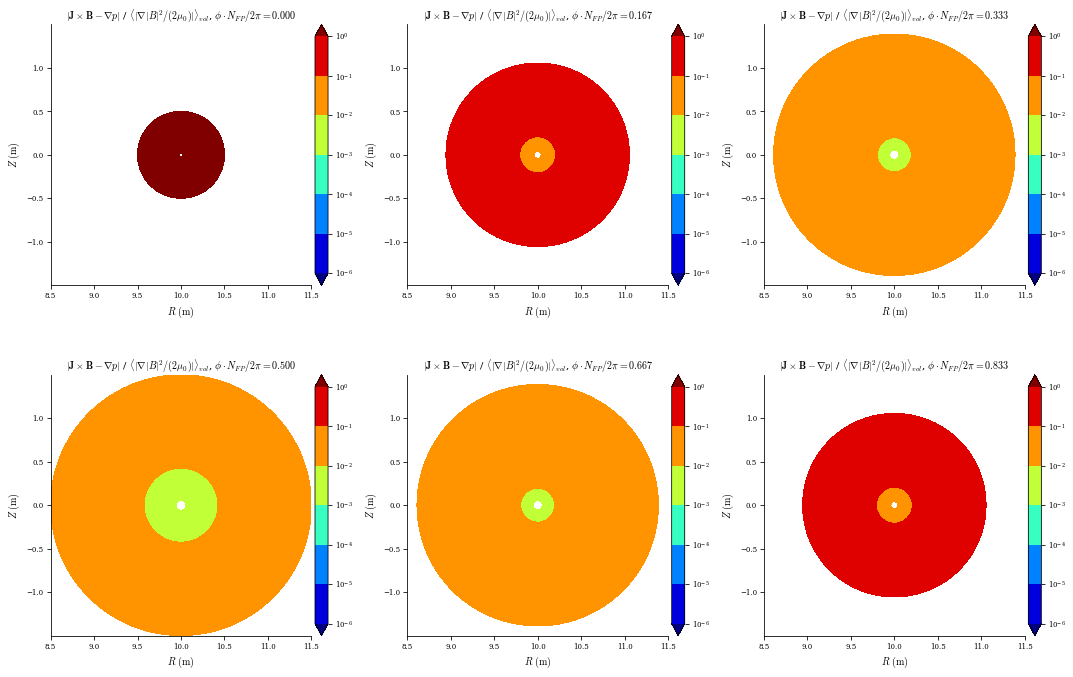

In [19]:
from desc.plotting import *

plot_section(eq_init, "|F|", norm_F=True, log=True)

In [33]:
## Are coils and surface aligned?

coil_data = ext_field.compute(["X", "Y", "Z"])
data = eq_init.compute(["X", "Y", "Z"], grid=grid)

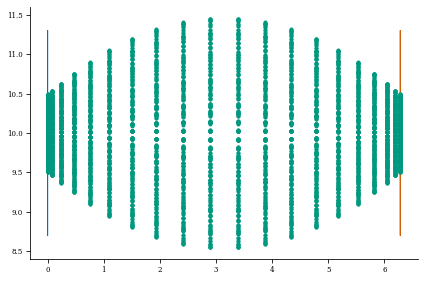

In [34]:
plt.figure()

for coils in coil_data:
    x = coils["X"]
    y = coils["Y"]
    z = coils["Z"]
    plt.plot(y, x)

x = data["X"]
y = data["Y"]
z = data["Z"]
plt.plot(y, x, ".")

In [39]:
eq2 = eq_init.copy()

In [42]:
constraints = (
    ForceBalance(eq=eq2),
    FixIota(eq=eq2),
    FixPressure(eq=eq2),
    FixPsi(eq=eq2),
    MatchEndCapR(eq=eq2),
    MatchEndCapZ(eq=eq2),
    MatchEndCapLambda(eq=eq2),
)

In [44]:
# For a standard free boundary solve, we set field_fixed=True. For single stage optimization, we would set to False
objective = ObjectiveFunction(BoundaryError(eq=eq2, field=ext_field, field_fixed=True))

Precomputing transforms


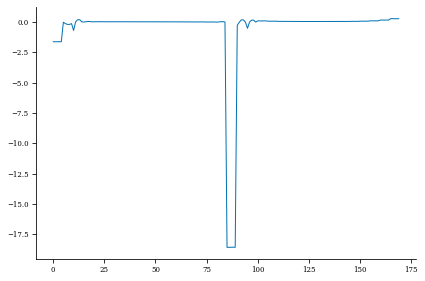

In [47]:
fb = BoundaryError(eq=eq2, field=ext_field, field_fixed=True)
fb.build()
fb_ = fb.compute(eq.params_dict)
plt.plot(fb_)

In [50]:
# we know this is a pretty simple shape so we'll only use |m| <= 2
# R_modes = eq2.surface.R_basis.modes[np.max(np.abs(eq2.surface.R_basis.modes), 1) > 2, :]
# Z_modes = eq2.surface.Z_basis.modes[np.max(np.abs(eq2.surface.Z_basis.modes), 1) > 2, :]
# bdry_constraints = (
#    FixBoundaryR(eq=eq2, modes=R_modes),
#    FixBoundaryZ(eq=eq2, modes=Z_modes),
# )
eq2, out = eq2.optimize(
    objective,
    constraints,  # + bdry_constraints,
    optimizer="proximal-lsq-exact",
    ftol=1e-8,
    xtol=1e-16,
    gtol=1e-16,
    maxiter=50,
    verbose=3,
)

Building objective: Boundary error
Precomputing transforms
Timer: Precomputing transforms = 1.33 ms
Timer: Objective build = 1.02 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 578 ms
Timer: Objective build = 631 ms
Timer: Objective build = 757 us
Timer: Eq Update LinearConstraintProjection build = 2.02 sec
Timer: Proximal projection build = 4.40 sec
Building objective: fixed iota
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: MatchR at Endcaps
Building objective: matchZ at Endcaps
Building objective: MatchL at Endcaps
Timer: Objective build = 351 ms
Timer: LinearConstraintProjection build = 1.20 sec
Number of parameters: 30
Number of objectives: 170
Timer: Initializing the optimization = 5.99 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.598e+02                          

(<Figure size 1080.81x720.54 with 12 Axes>,
 array([<Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axe

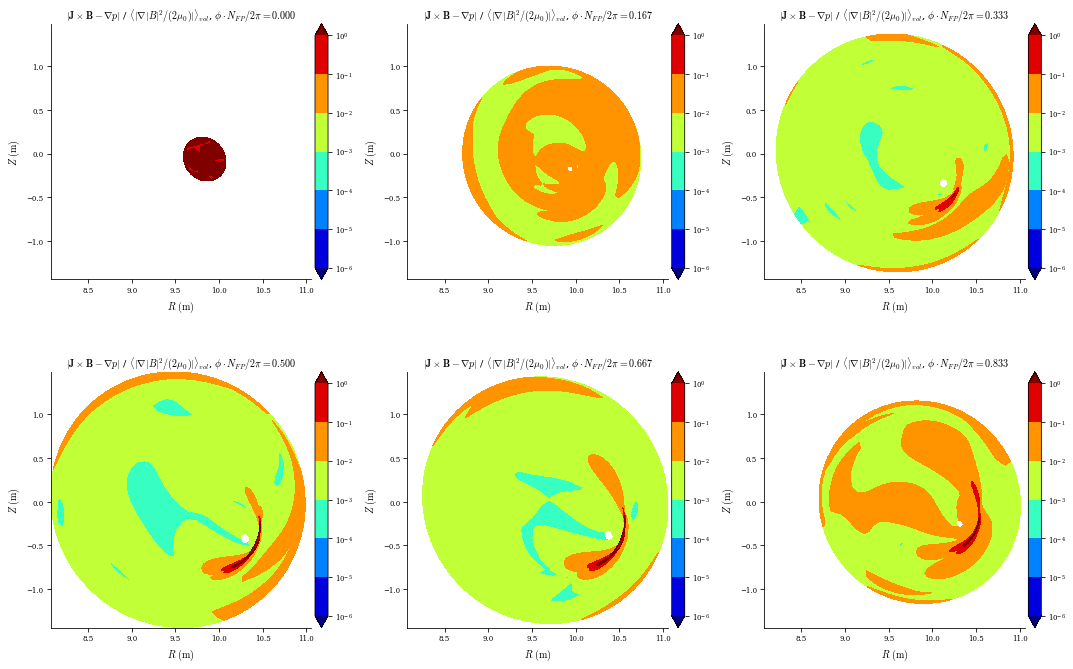

In [52]:
plot_section(eq2, "|F|", norm_F=True, log=True)

In [55]:
## Are coils and surface aligned?

coil_data = ext_field.compute(["X", "Y", "Z"])
data = eq2.compute(["X", "Y", "Z"], grid=grid)

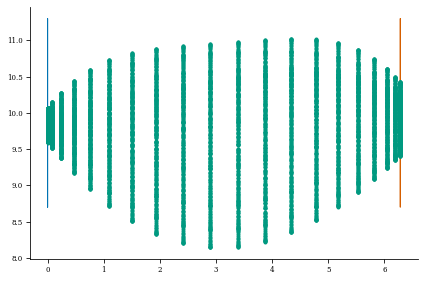

In [57]:
plt.figure()

for coils in coil_data:
    x = coils["X"]
    y = coils["Y"]
    z = coils["Z"]
    plt.plot(y, x)

x = data["X"]
y = data["Y"]
z = data["Z"]
plt.plot(y, x, ".")

In [ ]:
coords["X"].shape

In [ ]:
plt.figure()
plt.plot(coords["Y"], coords["Z"], ".")

In [175]:
# eq.current = eq.iota

In [176]:
eq.iota

PowerSeriesProfile at 0x3b8aeaa50 (name=, basis=PowerSeries at 0x32fc61580 (L=5, M=0, N=0, NFP=1, sym=even, spectral_indexing=linear))

In [177]:
eq.current

In [178]:
eq2 = eq.copy()

In [179]:
constraints = (
    ForceBalance(eq=eq2),
    FixCurrent(eq=eq2),
    FixPressure(eq=eq2),
    FixPsi(eq=eq2),
)

In [193]:
objective = ObjectiveFunction(
    VacuumBoundaryError(eq=eq2, field=ext_field, field_fixed=True)
)

In [190]:
objective.x

<bound method ObjectiveFunction.x of <desc.objectives.objective_funs.ObjectiveFunction object at 0x3cf1f2a80>>

In [181]:
for k in [2, 4]:

    # get modes where |m|, |n| > k
    R_modes = eq2.surface.R_basis.modes[
        np.max(np.abs(eq2.surface.R_basis.modes), 1) > k, :
    ]
    Z_modes = eq2.surface.Z_basis.modes[
        np.max(np.abs(eq2.surface.Z_basis.modes), 1) > k, :
    ]

    # fix those modes
    bdry_constraints = (
        FixBoundaryR(eq=eq2),  # , modes=R_modes),
        FixBoundaryZ(eq=eq2),  # , modes=Z_modes),
    )
    # optimize
    eq2, out = eq2.optimize(
        objective,
        # constraints ,#+ bdry_constraints,
        optimizer="proximal-lsq-exact",
        verbose=3,
        options={},
    )

Building objective: Vacuum boundary error


/Users/djinpatch/CODE/DESC/desc/utils.py:537: UserWarning:

Current is non-zero (max 885140.1396650695 A), VacuumBoundaryError will be incorrect.



Precomputing transforms
Timer: Precomputing transforms = 19.3 ms
Timer: Objective build = 216 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 25.1 ms
Timer: Objective build = 92.2 ms


/Users/djinpatch/CODE/DESC/desc/utils.py:537: UserWarning:


Not equal to tolerance rtol=3e-14, atol=3e-14
Incompatible constraints detected, cannot satisfy constraint <desc.objectives.linear_objectives.BoundaryRSelfConsistency object at 0x3d017b5f0>.
Mismatched elements: 3 / 45 (6.67%)
Max absolute difference: 4.54747351e-13
Max relative difference: inf
 x: array([-5.697656e-14,  2.052683e-48, -4.547474e-13, -4.607426e-15,
       -1.749857e-14,  1.282851e-14, -3.192332e-17, -8.966388e-15,
        2.136454e-14,  5.238865e-15,  2.866845e-14,  4.989018e-15,...
 y: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])
 This may indicate incompatible constraints, or be due to floating point error.

/Users/djinpatch/CODE/DESC/desc/utils.py:537: UserWarning:


Not equal to tolerance rtol=3e-14, atol=3e-14
Incompatible constraints detected, cannot satisfy constraint <desc.objectives.linear_o

Timer: Proximal projection build = 923 ms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed-Psi
Building objective: fixed-pressure
Building objective: fixed-iota
Timer: Objective build = 329 ms
Timer: Linear constraint projection build = 362 ms
Number of parameters: 0
Number of objectives: 594
Starting optimization
Using method: proximal-lsq-exact


ValueError: zero-size array to reduction operation max which has no identity